In [1]:
#Importing necessary libraries
from qiskit import *
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.circuit.library import PauliEvolutionGate
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import numpy as np
from qiskit.primitives import Estimator
#from qiskit.primitives import StatevectorEstimator
from scipy.optimize import minimize
from scipy.optimize._optimize import OptimizeResult

In [3]:
# Define Cost Hamiltonian (diagonal form)
cost_diag = np.array([0.0, 2.0, 2.0, 1.0])
H_C = SparsePauliOp.from_operator(np.diag(cost_diag))

In [5]:
# Define Mixer Hamiltonian
H_Q = SparsePauliOp.from_list([("II", 2.0), ("XI", -1.0), ("IX", -1.0)])


In [7]:
def build_qwoa_circuit(gamma, beta):
    qc = QuantumCircuit(2)
    qc.h([0, 1])  # Initial state |+>|+>
    qc.append(PauliEvolutionGate(H_C, time=gamma), [0, 1])
    qc.append(PauliEvolutionGate(H_Q, time=beta), [0, 1])
    return qc

In [9]:
# Estimator for expectation value
estimator = Estimator()

/var/folders/y7/ccw1r_j95vbbswqv7lqbg04c0000gn/T/ipykernel_9178/2286815098.py:2: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


In [11]:
# Objective function for classical optimizer
#from qiskit.primitives import EstimatorResultInput

def objective(params):
    gamma, beta = params
    qc = build_qwoa_circuit(gamma, beta)
    job = estimator.run(circuits=[qc], observables=[H_C])
    exp_val = job.result().values[0]
    return np.real(exp_val)


In [13]:
# Initial parameters
initial_params = [1.0, 1.0]

In [15]:
# Run classical optimization
opt_result = minimize(objective, initial_params, method='Nelder-Mead')

In [17]:
# Display results
print("\nOptimal Parameters:")
print("gamma =", opt_result.x[0])
print("beta  =", opt_result.x[1])
print("Minimum Cost =", opt_result.fun)



Optimal Parameters:
gamma = 0.9118969423851035
beta  = 0.42566129604848746
Minimum Cost = 0.4805236825335073


In [19]:
final_circuit = build_qwoa_circuit(opt_result.x[0], opt_result.x[1])
#print("\nFinal optimized circuit:")
#print(final_circuit.draw('text'))

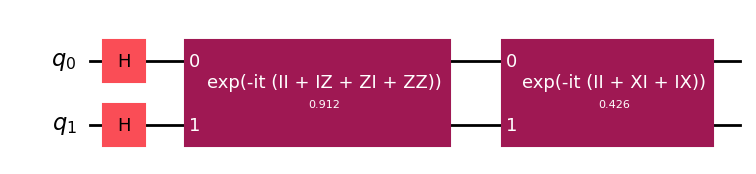

In [21]:
final_circuit.draw('mpl')

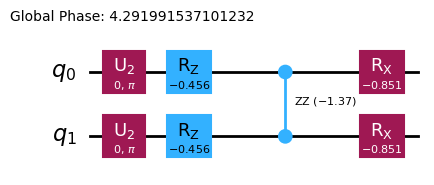

In [23]:
final_circuit.decompose().draw('mpl')

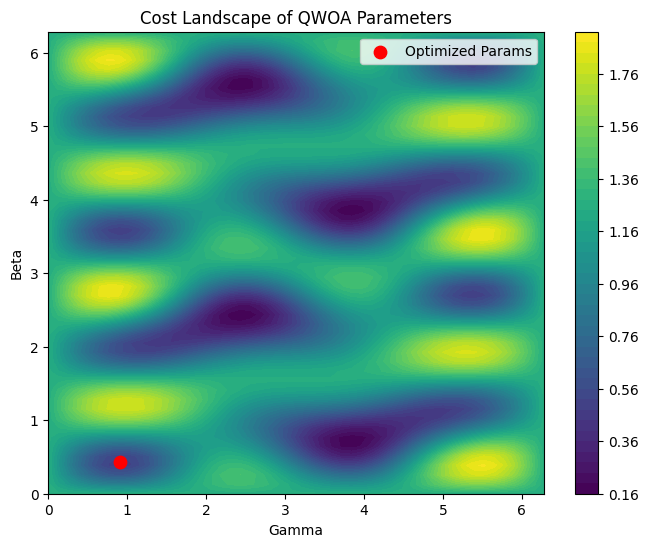

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Define the grid for gamma and beta
gammas = np.linspace(0, 2*np.pi, 50)
betas = np.linspace(0, 2*np.pi, 50)
cost_vals = np.zeros((len(gammas), len(betas)))

# Evaluate the cost function on the parameter grid
for i, g in enumerate(gammas):
    for j, b in enumerate(betas):
        cost_vals[i, j] = objective([g, b])  # Your objective function

# Plotting
plt.figure(figsize=(8, 6))
G, B = np.meshgrid(gammas, betas)

# Transpose for correct orientation
cp = plt.contourf(G, B, cost_vals.T, levels=50, cmap='viridis')
plt.colorbar(cp)

# Labels and title
plt.xlabel('Gamma')
plt.ylabel('Beta')
plt.title('Cost Landscape of QWOA Parameters')

# Scatter the optimal point found by Scipy
plt.scatter(opt_result.x[0], opt_result.x[1], color='red', label='Optimized Params', s=80)
plt.legend()

plt.show()


NLopt Optimal Parameters:
gamma = 2.4464452250134228
beta  = 5.569859175774944
Minimum Cost = 0.1622466216964482


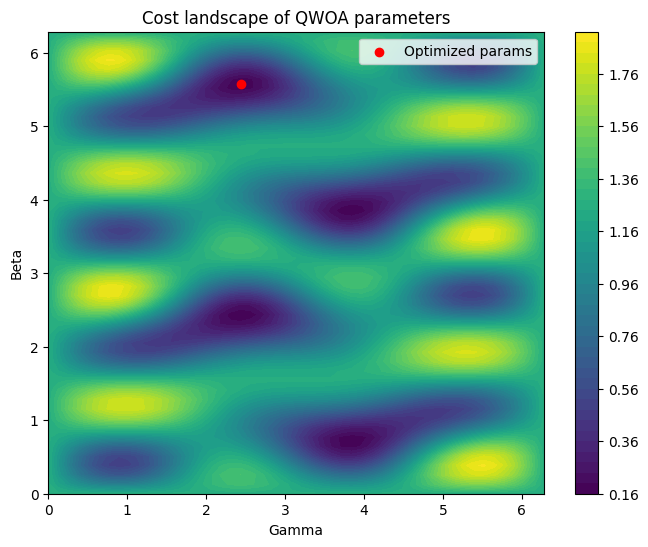

In [31]:
import nlopt
import numpy as np
import matplotlib.pyplot as plt

# existing objective function :
def objective(params):
    gamma, beta = params
    qc = build_qwoa_circuit(gamma, beta)
    job = estimator.run(circuits=[qc], observables=[H_C])
    exp_val = job.result().values[0]
    return np.real(exp_val)

def nlopt_objective(x, grad):
    return objective(x)

opt = nlopt.opt(nlopt.LN_NELDERMEAD, 2)
opt.set_min_objective(nlopt_objective)
opt.set_lower_bounds([-10, -10])
opt.set_upper_bounds([10, 10])
opt.set_xtol_rel(1e-6)
opt.set_maxeval(100)

initial_params = [1.0, 1.0]
x_opt = opt.optimize(initial_params)
min_cost = opt.last_optimum_value()

print("\nNLopt Optimal Parameters:")
print("gamma =", x_opt[0])
print("beta  =", x_opt[1])
print("Minimum Cost =", min_cost)

# Now plot
gammas = np.linspace(0, 2*np.pi, 50)
betas = np.linspace(0, 2*np.pi, 50)
cost_vals = np.zeros((len(gammas), len(betas)))

for i, g in enumerate(gammas):
    for j, b in enumerate(betas):
        cost_vals[i, j] = objective([g, b])

plt.figure(figsize=(8,6))
G, B = np.meshgrid(gammas, betas)
cp = plt.contourf(G, B, cost_vals.T, levels=50, cmap='viridis')
plt.colorbar(cp)
plt.xlabel('Gamma')
plt.ylabel('Beta')
plt.title('Cost landscape of QWOA parameters')
plt.scatter(x_opt[0], x_opt[1], color='red', label='Optimized params')
plt.legend()
plt.show()

In [ ]:
plt.hist(cost_vals.flatten(), bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Cost')
plt.ylabel('Frequency')
plt.title('Histogram of Cost Values over parameter grid')
plt.show()

In [25]:

final_circuit.measure_all()
backend = AerSimulator()
t_circuit = transpile(final_circuit, backend)
t_circuit.save_statevector()

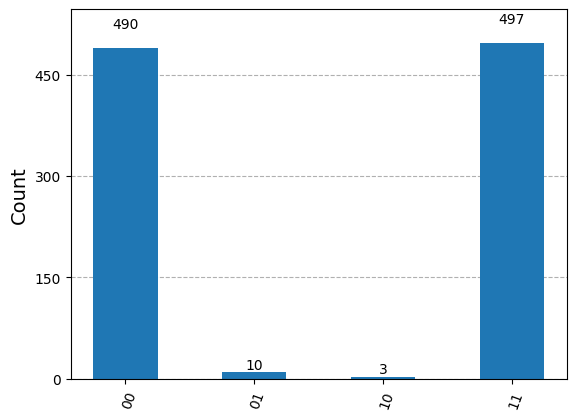

In [27]:

job = backend.run(t_circuit, shots=1000)
result = job.result()
counts = result.get_counts()

plot_histogram(counts)

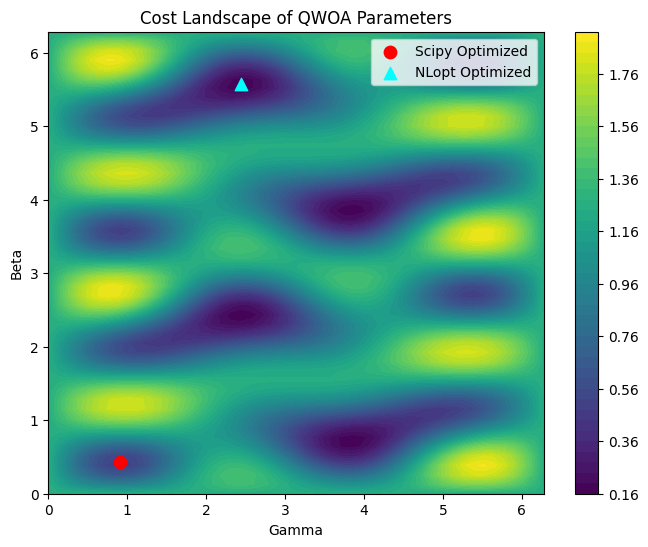

In [33]:

# Generate the parameter grid
gammas = np.linspace(0, 2*np.pi, 50)
betas = np.linspace(0, 2*np.pi, 50)
cost_vals = np.zeros((len(gammas), len(betas)))

# Compute the cost for each parameter pair
for i, g in enumerate(gammas):
    for j, b in enumerate(betas):
        cost_vals[i, j] = objective([g, b])

# Plotting the heatmap
plt.figure(figsize=(8, 6))
G, B = np.meshgrid(gammas, betas)
cp = plt.contourf(G, B, cost_vals.T, levels=50, cmap='viridis')
plt.colorbar(cp)
plt.xlabel('Gamma')
plt.ylabel('Beta')
plt.title('Cost Landscape of QWOA Parameters')

# Scatter: optimized parameters from Scipy
plt.scatter(opt_result.x[0], opt_result.x[1], color='red', label='Scipy Optimized', s=80, marker='o')

# Scatter: optimized parameters from NLopt
nlopt_gamma = 2.4464452250134228
nlopt_beta = 5.569859175774944
plt.scatter(nlopt_gamma, nlopt_beta, color='cyan', label='NLopt Optimized', s=80, marker='^')

# Add legend
plt.legend()
plt.show()